# Which seasonal windows and locations optimize safety—combining sunshine hours, wind-gust flags, and frost/heat indicators?

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Climalyticsat_RQ4').getOrCreate()

climate_data = spark.read.csv('climate_all_stations.csv', header=True, inferSchema=True)
parameter_metadata = spark.read.csv('parameter_metadata.csv', header=True, inferSchema=True)
stations_metadata = spark.read.csv('stations_metadata.csv', header=True, inferSchema=True)

In [ ]:
climate_data.printSchema()

In [3]:
parameter_metadata.printSchema()

root
 |-- Parameterkürzel: string (nullable = true)
 |-- Kurzbeschreibung: string (nullable = true)
 |-- Beschreibung: string (nullable = true)
 |-- Einheit: string (nullable = true)



In [4]:
stations_metadata.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Synopstationsnummer: integer (nullable = true)
 |-- Stationsname: string (nullable = true)
 |-- Länge [°E]: double (nullable = true)
 |-- Breite [°N]: double (nullable = true)
 |-- Höhe [m]: double (nullable = true)
 |-- Startdatum: timestamp (nullable = true)
 |-- Enddatum: timestamp (nullable = true)
 |-- Bundesland: string (nullable = true)
 |-- Sonnenschein: boolean (nullable = true)
 |-- Globalstrahlung: boolean (nullable = true)
 |-- Synop: string (nullable = true)
 |-- Verknüpfungsnummer: integer (nullable = true)
 |-- Startdatum Teilzeitreihe: timestamp (nullable = true)
 |-- Enddatum Teilzeitreihe: timestamp (nullable = true)
 |-- zusammengesetzt: string (nullable = true)



In [5]:
climate_data.rdd.getNumPartitions()


8

In [8]:
from pyspark.sql.functions import month, when, avg, sum, col

# Add month column
climate_data = climate_data.withColumn('month', month(col('date')))

# Define season UDF or mapping:
def season_from_month(m):
    if m in [12, 1, 2]: return 'Winter'
    elif m in [3,4,5]: return 'Spring'
    elif m in [6,7,8]: return 'Summer'
    else: return 'Autumn'

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
season_udf = udf(season_from_month, StringType())

climate_data = climate_data.withColumn('season', season_udf(col('month')))

# Select relevant flags/columns - example column names
selected_cols = [
    'station_id', 'season',
    'tage_sh_manu_100_flag',  # wind gust flags
    'tage_frost_flag',        # frost indicator
    'tage_heit_flag',         # heat indicator
    'Sonnenschein'            # sunshine hours, if available in stations_metadata
]

# Join stations_metadata to get 'Sonnenschein' (boolean or numeric)
climate_data = climate_data.join(stations_metadata.select('id', 'Sonnenschein'), climate_data.station_id == stations_metadata.id, 'left')

# Aggregate per station and season: mean or sum of flags, average sunshine if numeric
agg_df = climate_data.groupBy('station_id', 'season').agg(
    avg('tage_sh_manu_100_flag').alias('avg_wind_gust_flag'),
    avg('tage_frost_flag').alias('avg_frost_flag'),
    avg('tage_heit_flag').alias('avg_heat_flag'),
    avg(col('Sonnenschein').cast('double')).alias('avg_sunshine')  # cast if boolean
)

# Calculate a safety score (example formula):
# More sunshine (+), less wind gust, frost, heat flags (-)
from pyspark.sql.functions import expr

agg_df = agg_df.withColumn('safety_score', 
    col('avg_sunshine') - (col('avg_wind_gust_flag') + col('avg_frost_flag') + col('avg_heat_flag'))
)

# Get top safe locations and seasons
top_safe = agg_df.orderBy(col('safety_score').desc()).limit(10)

# Collect and show
top_safe_pd = top_safe.toPandas()
print(top_safe_pd)


   station_id  season  avg_wind_gust_flag  avg_frost_flag  avg_heat_flag  \
0       16440  Autumn                 0.0             0.0            0.0   
1       19010  Spring                 0.0             0.0            0.0   
2       16440  Summer                 0.0             0.0            0.0   
3       16440  Spring                 0.0             0.0            0.0   
4       18720  Spring                 0.0             0.0            0.0   
5       19010  Winter                 0.0             0.0            0.0   
6       18801  Summer                 0.0             0.0            0.0   
7       18801  Winter                 0.0             0.0            0.0   
8       18720  Winter                 0.0             0.0            0.0   
9       19010  Summer                 0.0             0.0            0.0   

   avg_sunshine  safety_score  
0           1.0           1.0  
1           1.0           1.0  
2           1.0           1.0  
3           1.0           1.0  
4  

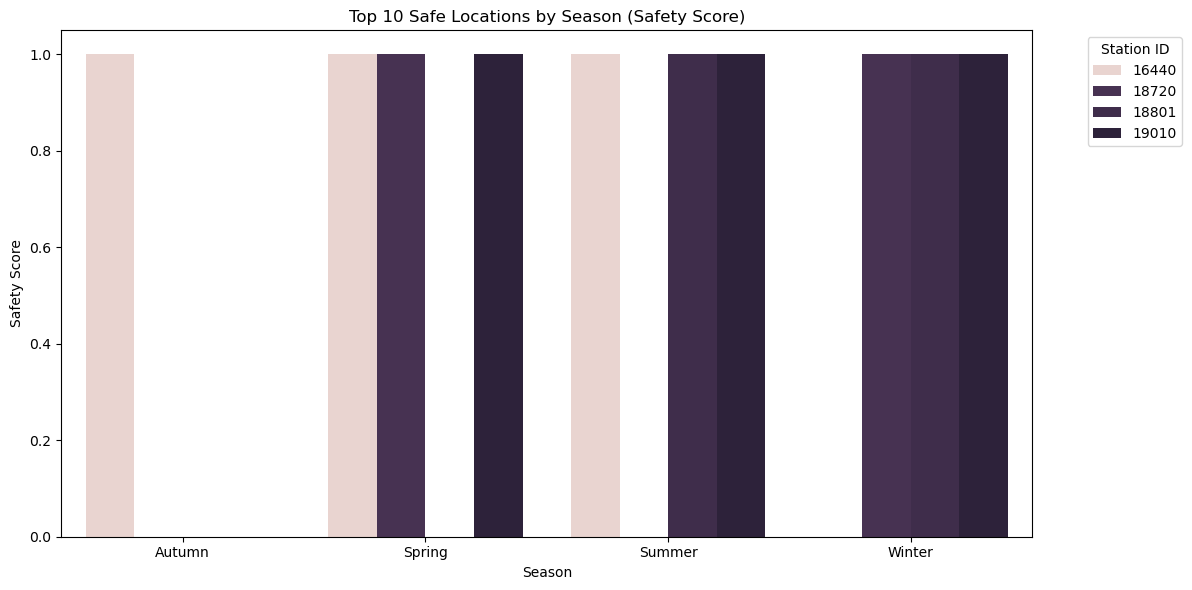

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=top_safe_pd, x='season', y='safety_score', hue='station_id')
plt.title('Top 10 Safe Locations by Season (Safety Score)')
plt.ylabel('Safety Score')
plt.xlabel('Season')
plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 3.4 MB/s eta 0:00:00


In [28]:
import folium
import pandas as pd
from IPython.display import IFrame
# Join station coordinates to safety scores (agg_df from previous step)
station_coords = stations_metadata.select(
    col('id').alias('station_id'),
    col('Länge [°E]').alias('lon'),
    col('Breite [°N]').alias('lat'),
    col('Stationsname')
)

safety_with_coords = agg_df.join(station_coords, 'station_id')

# Convert to Pandas
safety_pd = safety_with_coords.toPandas()

# Filter to one season or loop through seasons for multiple maps
season = 'Summer'  # example
safety_season = safety_pd[safety_pd['season'] == season]

# Create folium map centered in Austria (~47.5N, 13.5E)
m = folium.Map(location=[47.5, 13.5], zoom_start=7)

# Normalize safety_score for circle size/color
min_score = safety_season['safety_score'].min()
max_score = safety_season['safety_score'].max()
score_range = max_score - min_score if max_score != min_score else 1

def normalize_score(score):
    return (score - min_score) / score_range

for _, row in safety_season.iterrows():
    radius = 5 + 15 * normalize_score(row['safety_score'])  # size by safety
    color = 'green' if row['safety_score'] > 0 else 'red'  # color by safety
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['Stationsname']}<br>Safety: {row['safety_score']:.2f}"
    ).add_to(m)

# Save or display
m.save('safety_map.html')
IFrame('safety_map.html', width=1200, height=700)
